<h2><b>Scraping Hands-On 1</b></h2>

We want to apply the same interactions to another web page with reviews: Google Maps.

Follow the example on slides to reproduce the same interactions on Google Maps.

In [6]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
from IPython.display import Image, display, clear_output
# from pymongo import MongoClient
import re
import time

MAX_WAIT = 10

In [7]:
def take_screenshot(driver):
    driver.save_screenshot("pageImage.png")
    display(Image(filename='pageImage.png'))
    print()

In [8]:
def take_screenshot_and_clear(driver):
    driver.save_screenshot("pageImage.png")
    display(Image(filename='pageImage.png'))
    
    time.sleep(3)
    clear_output(wait=True)

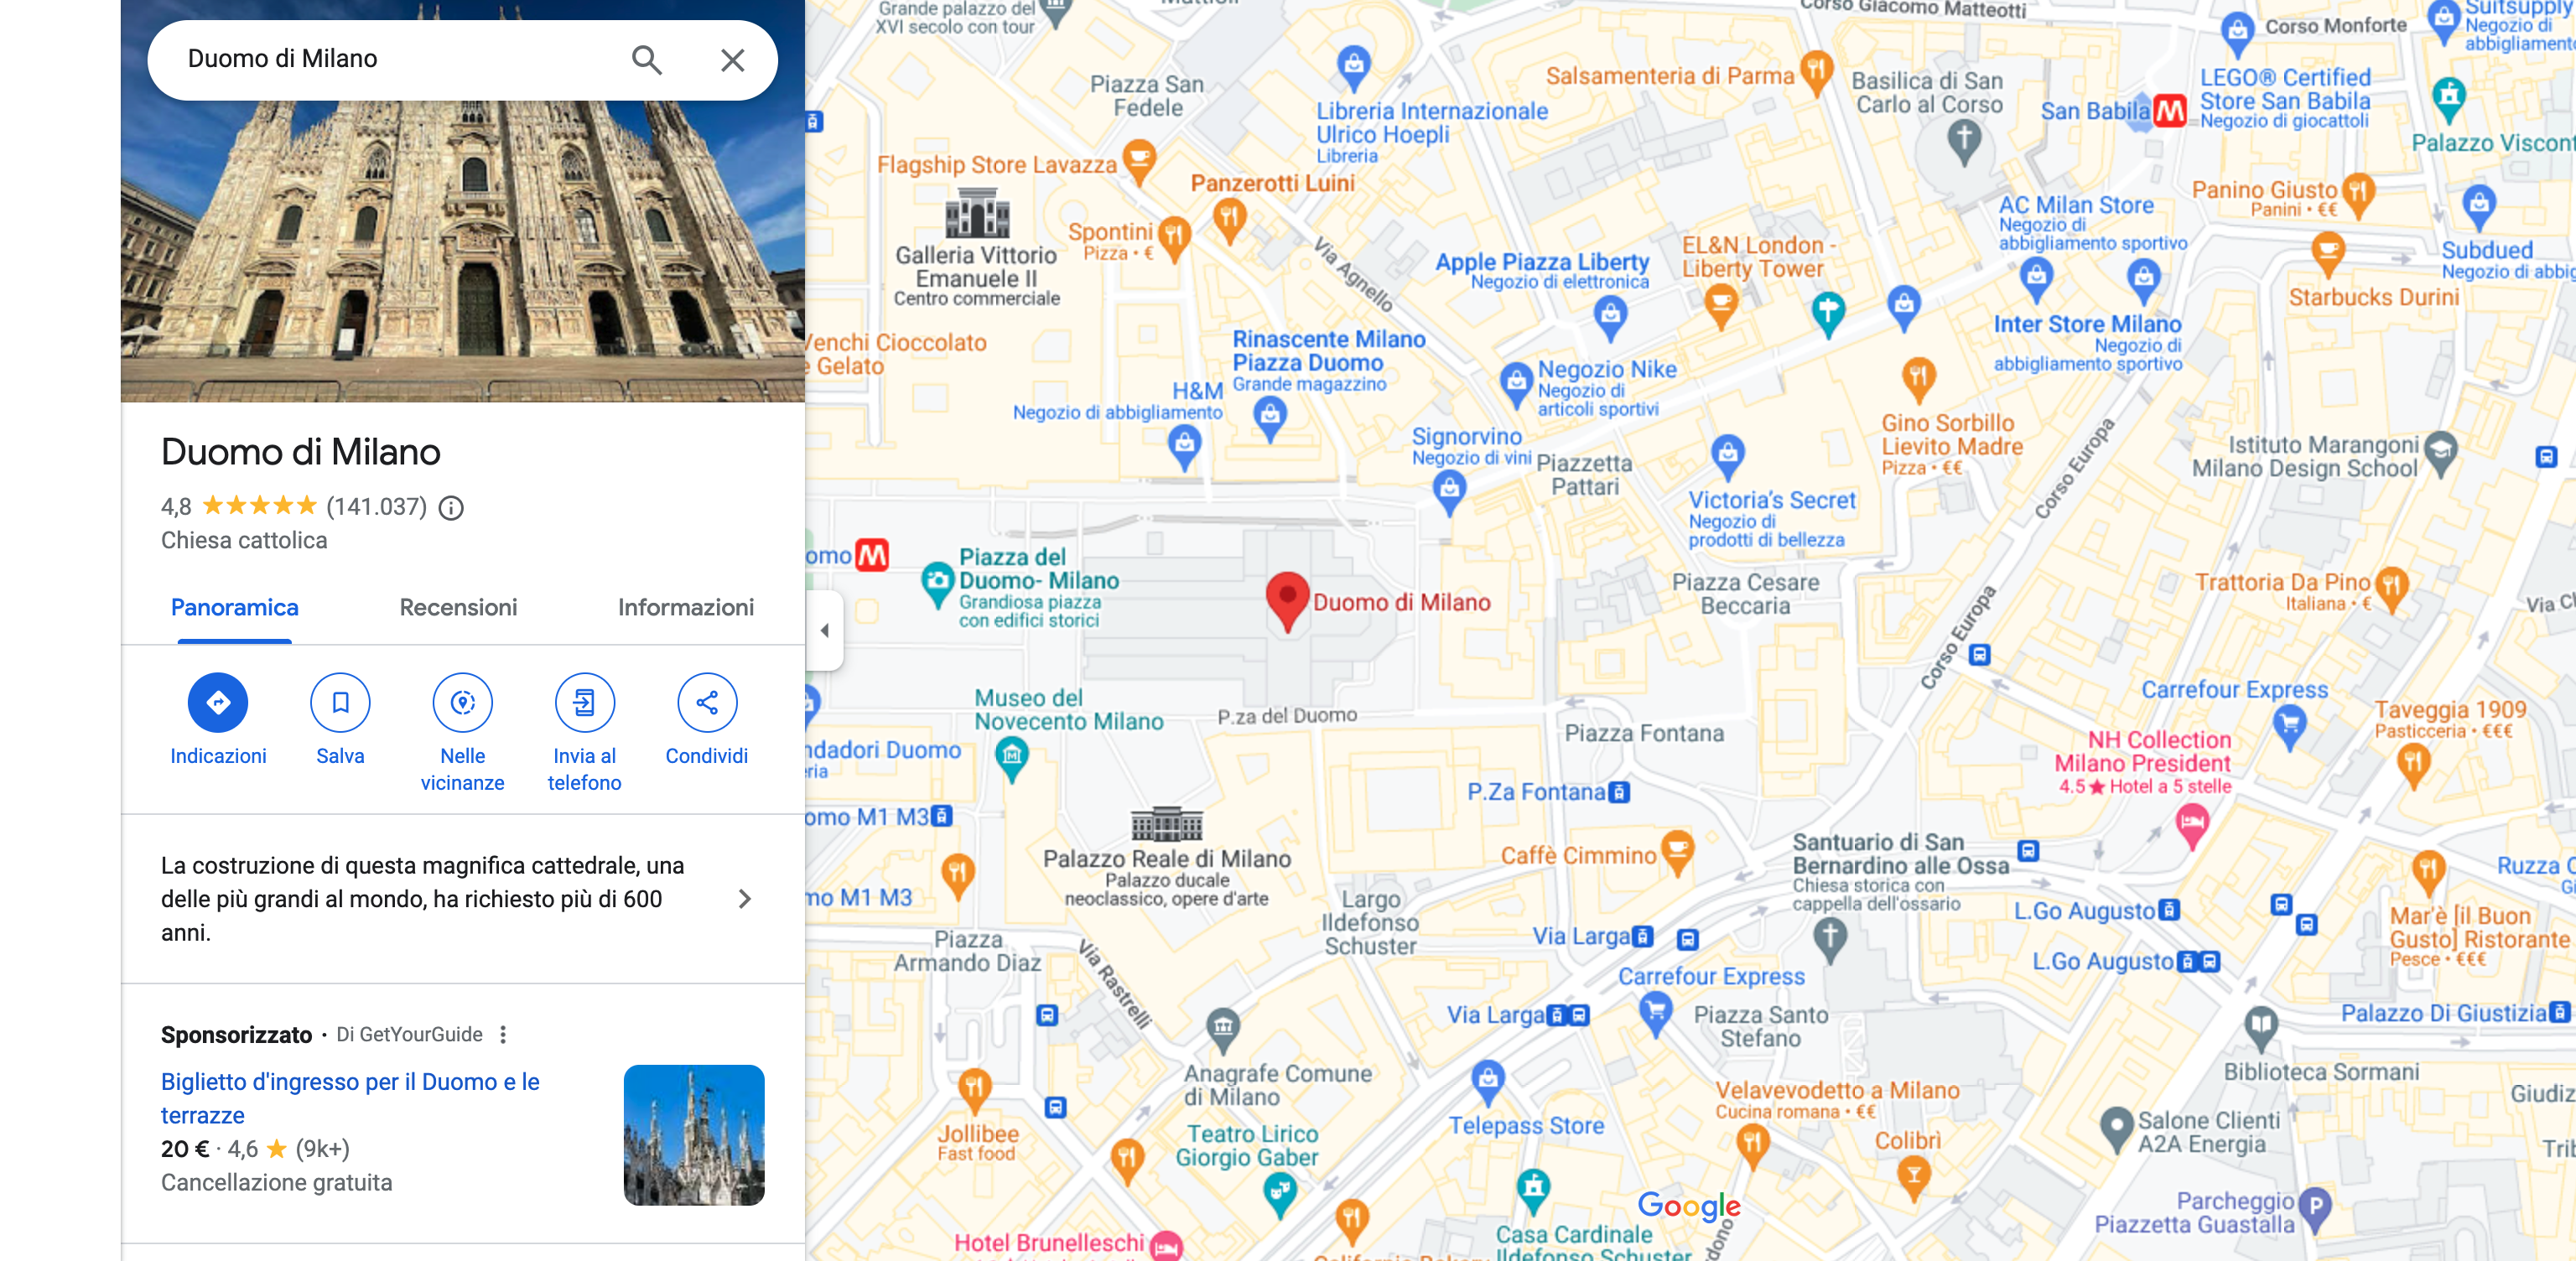


{'name': '', 'rating': 4.8, 'address': 'P.za del Duomo, 20122 Milano MI', 'type': 'Chiesa cattolica'}


In [ ]:
# Option object allows to set several options for the driver
options = Options()

# size of the browser window automatically opened
options.add_argument("--window-size=1920,1080")

# useful to avoid pop-up during automatic navigation
options.add_argument("--disable-notifications")

# options.binary_location = "C:/Program Files/Google/Chrome/Application/chrome.exe"

# Selenium (Chrome) driver with the options defined
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# set up DB connection for saving results
# client = MongoClient('mongodb://localhost:27017/')
# db = client['bip']['gm_place']
# db.drop()

# input file, containing a list of urls
urls = open('places_gm.txt')

accept_privacy = True

# iterate over the file and scrape data from each url
for url in urls:

    # get the page
    driver.get(url)
    
    if(accept_privacy):
        take_screenshot_and_clear(driver)
    
    # wait element
    wait = WebDriverWait(driver, MAX_WAIT)
    
    # accept privacy, if needed
    if(accept_privacy):
        privacy_buttons = driver.find_elements(By.CLASS_NAME, 'lssxud')
        
        if len(privacy_buttons) > 0:
            wait.until(EC.element_to_be_clickable((By.CLASS_NAME, 'AIC7ge')))
            privacy_buttons[1].find_element(By.TAG_NAME, 'button').click()
        
        accept_privacy = False
    
    # wait for content to load
    wait.until(EC.visibility_of_element_located((By.XPATH, '//*[@id="QA0Szd"]/div/div/div[1]/div[2]/div/div[1]/div/div/div[1]/div[1]/button/img')))

    take_screenshot(driver)
    
    # send the page extracted with Selenium to BeautifulSoap parser
    response = BeautifulSoup(driver.page_source, 'html.parser')
    
    # prepare a dictionary to store results
    place = {}

    # get place name
    name = response.find('h1', class_= "DUwDvf").find('span').text
    place['name'] = name
    
    # get number of reviews
    #n_reviews = response.find('div', class_='F7nice').find('button').text.replace('.', '')

    # casting to correct type
    #n_reviews = int(n_reviews.split(' ')[0])
    #place['review'] = n_reviews

    # get rating using
    overall_rating = response.find('div', class_= 'F7nice').find('span').find('span').text

    # casting to correct type
    overall_rating = float(overall_rating.replace(',', '.'))
    place['rating'] = overall_rating

    # get address
    complete_address = response.find('div', class_='Io6YTe').text
    place['address'] = complete_address.strip()

    # get type of place
    type = response.find('button', class_='DkEaL').text
    place['type'] = type

    # save result into MongoDB collection
    # db.insert_one(place)
    print(place)
    
    time.sleep(3)
    clear_output(wait=True)

# close file
urls.close()

# close driver and quit
driver.close()
driver.quit()

# close db connection
# client.close()